In [2]:
import numpy as np
import torch
import gpytorch
import torch.nn as nn
import matplotlib.pyplot as plt

# ------------------ Reproducibility ------------------
torch.manual_seed(0)
np.random.seed(0)

# ------------------ Load and Preprocess Data ------------------
data_np = np.load("spatial_temporal_data.npy")
data = data_np[50:60, 100:110, :100]  # (H=10, W=10, T=100)

data_mean = data.mean()
data_std = data.std()
data = (data - data_mean) / (data_std + 1e-8)

H, W, T = data.shape

# ------------------ Uniform (Stratified) Training Location Selection (Option A) ------------------
def pick_uniform_grid_points(H, W, n_points, rng):
    """
    Stratified sampling: pick approximately evenly spaced points on a lattice,
    then fill remaining points uniformly at random from leftover grid points.
    """
    n_side = int(np.floor(np.sqrt(n_points)))  # e.g., 3 for 15 -> 9 lattice points
    xs = np.linspace(0, H - 1, n_side, dtype=int)
    ys = np.linspace(0, W - 1, n_side, dtype=int)

    chosen = {(int(x), int(y)) for x in xs for y in ys}

    all_pts = [(i, j) for i in range(H) for j in range(W)]
    remaining = [p for p in all_pts if p not in chosen]

    need = n_points - len(chosen)
    if need > 0:
        extra_idx = rng.choice(len(remaining), size=need, replace=False)
        for k in extra_idx:
            chosen.add(remaining[k])

    chosen = np.array(sorted(list(chosen)), dtype=int)
    return chosen

rng = np.random.default_rng(seed=42)
train_locs = pick_uniform_grid_points(H, W, n_points=15, rng=rng)  # (15, 2)

print("Trained spatial locations (x, y):", [tuple(loc) for loc in train_locs])

train_x_space = torch.tensor(train_locs, dtype=torch.float32)            # (15, 2)
train_x_time = torch.arange(T, dtype=torch.float32).unsqueeze(1)         # (T, 1)

# ------------------ Build Training Dataset ------------------
train_inputs, train_outputs = [], []
for i, (x_idx, y_idx) in enumerate(train_locs):
    ts = data[int(x_idx), int(y_idx), :]                                  # (T,)
    loc_tensor = train_x_space[i].repeat(T, 1)                             # (T, 2)
    train_inputs.append(torch.cat([loc_tensor, train_x_time], dim=1))      # (T, 3)
    train_outputs.append(torch.tensor(ts, dtype=torch.float32))            # (T,)

train_x = torch.cat(train_inputs, dim=0)   # (15*T, 3)
train_y = torch.cat(train_outputs, dim=0)  # (15*T,)

# Normalize inputs to [0,1]
train_x_norm = train_x.clone()
train_x_norm[:, 0] /= (H - 1)
train_x_norm[:, 1] /= (W - 1)
train_x_norm[:, 2] /= (T - 1)

# ------------------ DKL Spatial Feature Extractor ------------------
class SpatialFeatureExtractor(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=32, out_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x_space):
        return self.net(x_space)

# ------------------ Case 2 Model: Sum over R separable components ------------------
class SpatioTemporalDKLModel_Case2(gpytorch.models.ExactGP):
    """
    Case 2:
        k((x,t),(x',t')) = sum_{r=1}^R kx^{(r)}(phi(x),phi(x')) * kt^{(r)}(t,t')

    - Spatial: shared DKL feature extractor + per-r RBF in feature space
    - Time: per-r SpectralMixtureKernel on time
    """
    def __init__(self, train_x, train_y, likelihood, R=3, time_num_mixtures=4):
        super().__init__(train_x, train_y, likelihood)

        self.R = int(R)
        self.time_num_mixtures = int(time_num_mixtures)

        self.mean_module = gpytorch.means.ConstantMean()

        # Shared DKL feature extractor
        self.feature_extractor = SpatialFeatureExtractor(in_dim=2, hidden_dim=32, out_dim=8)

        # Per-component spatial + temporal kernels
        self.space_kernels = nn.ModuleList()
        self.time_kernels = nn.ModuleList()

        for r in range(self.R):
            self.space_kernels.append(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            )

            sm = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=self.time_num_mixtures)
            sm.initialize_from_data(train_x[:, 2:3], train_y)  # time dim (normalized)
            self.time_kernels.append(sm)

    def forward(self, x):
        mean_x = self.mean_module(x)

        x_space = x[..., :2]   # (N,2)
        x_time  = x[..., 2:3]  # (N,1)

        z = self.feature_extractor(x_space)  # (N,d)

        covar = None
        for r in range(self.R):
            Kx_r = self.space_kernels[r](z)
            Kt_r = self.time_kernels[r](x_time)
            Kr = Kx_r * Kt_r
            covar = Kr if covar is None else (covar + Kr)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

# ------------------ Train GP ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x_norm = train_x_norm.to(device)
train_y = train_y.to(device)

R = 3
time_num_mixtures = 4

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = SpatioTemporalDKLModel_Case2(
    train_x_norm, train_y, likelihood, R=R, time_num_mixtures=time_num_mixtures
).to(device)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iters = 100
for i in range(training_iters):
    optimizer.zero_grad()
    output = model(train_x_norm)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

    if (i + 1) % 10 == 0:
        print(f"Iter {i+1:3d}/{training_iters} - Loss: {loss.item():.3f}")

# ------------------ Predict on Full Grid ------------------
test_inputs = []
train_x_time_cpu = torch.arange(T, dtype=torch.float32).unsqueeze(1)

for i in range(H):
    for j in range(W):
        spatial = torch.tensor([i, j], dtype=torch.float32).repeat(T, 1)
        temporal = train_x_time_cpu
        combined = torch.cat([spatial, temporal], dim=1)
        test_inputs.append(combined)

test_x = torch.cat(test_inputs, dim=0)

test_x_norm = test_x.clone()
test_x_norm[:, 0] /= (H - 1)
test_x_norm[:, 1] /= (W - 1)
test_x_norm[:, 2] /= (T - 1)

test_x_norm = test_x_norm.to(device)

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(test_x_norm))
    pred_mean = pred_dist.mean.view(H, W, T)

pred_mean_np = pred_mean.detach().cpu().numpy()


Trained spatial locations (x, y): [(0, 0), (0, 4), (0, 9), (1, 0), (4, 0), (4, 2), (4, 3), (4, 4), (4, 9), (6, 3), (7, 3), (8, 4), (9, 0), (9, 4), (9, 9)]
Iter  10/100 - Loss: 0.489
Iter  20/100 - Loss: 0.037
Iter  30/100 - Loss: -0.397
Iter  40/100 - Loss: -0.830
Iter  50/100 - Loss: -0.881
Iter  60/100 - Loss: -0.931
Iter  70/100 - Loss: -0.863
Iter  80/100 - Loss: -0.837
Iter  90/100 - Loss: -0.902
Iter 100/100 - Loss: -0.925


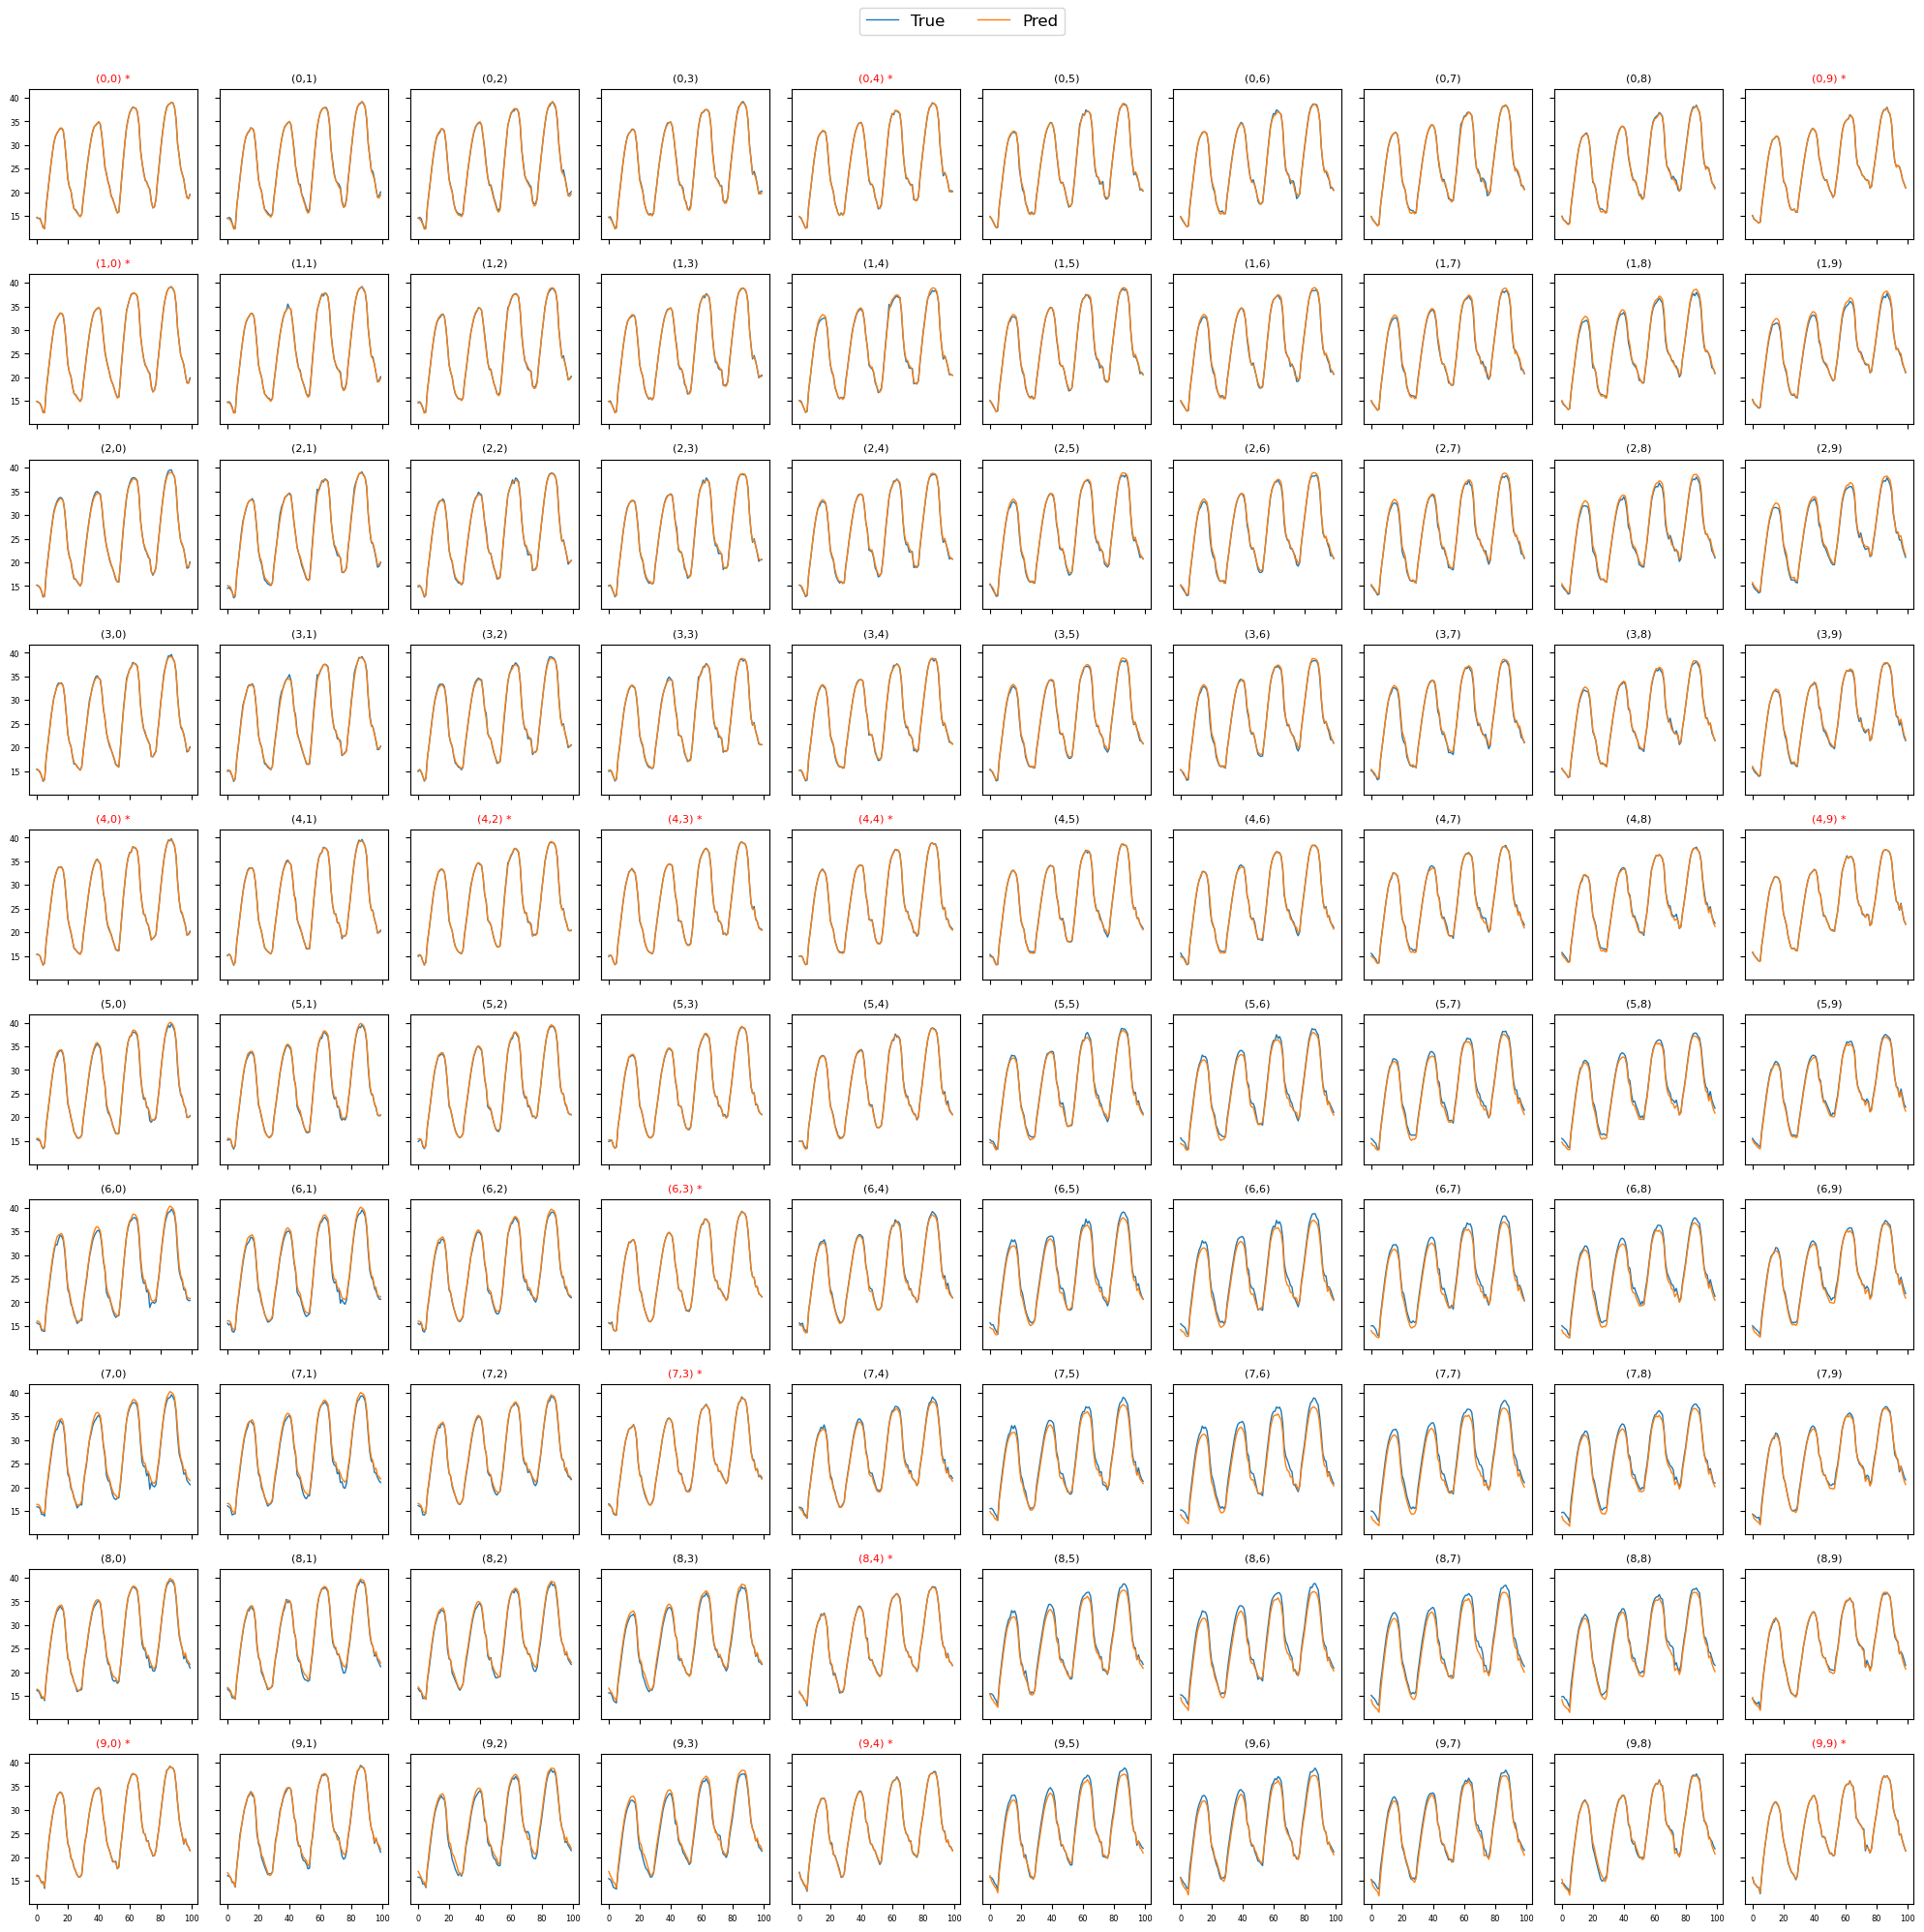

In [3]:
train_locs_set = set(map(tuple, train_locs.tolist()))

fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        # de-normalize to true temperature units
        true_ts = data[i, j, :] * data_std + data_mean
        pred_ts = pred_mean_np[i, j, :] * data_std + data_mean

        axs[i, j].plot(true_ts, label="True", linewidth=1)
        axs[i, j].plot(pred_ts, label="Pred", linewidth=1)

        is_train = (i, j) in train_locs_set
        title = f"({i},{j})" + (" *" if is_train else "")
        axs[i, j].set_title(title, fontsize=8, color="red" if is_train else "black")
        axs[i, j].tick_params(labelsize=6)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


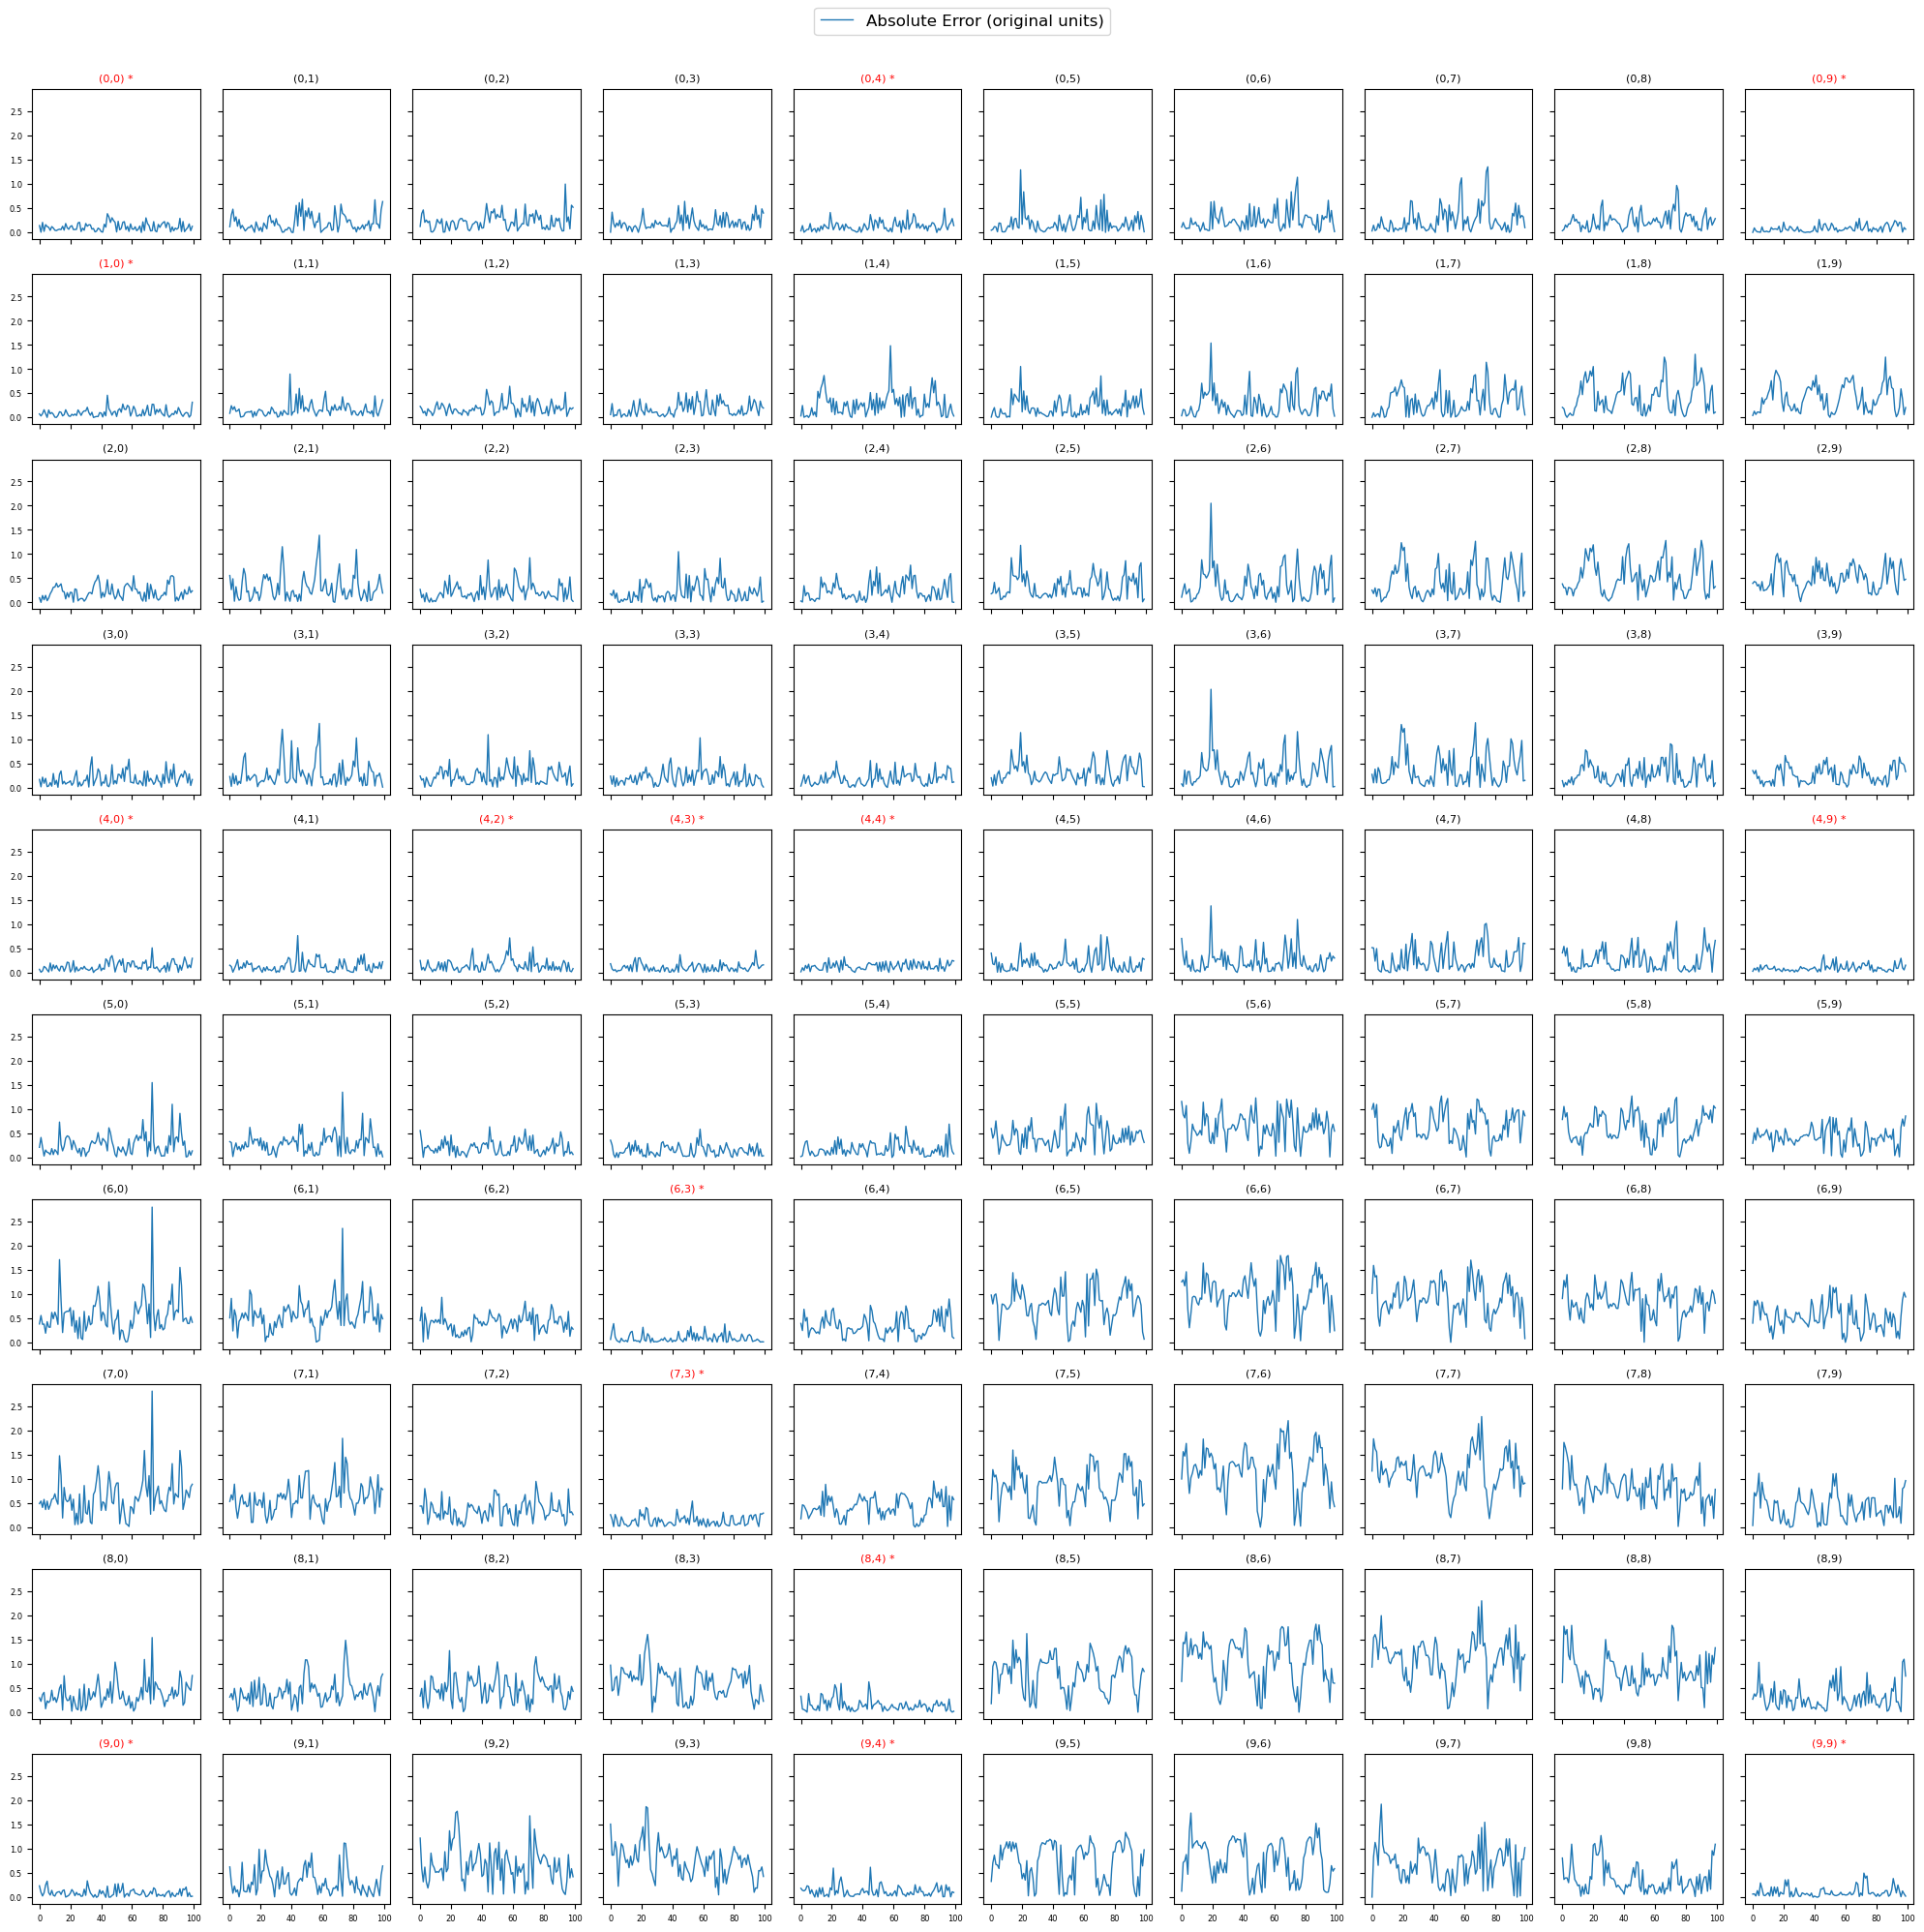

In [4]:
# Absolute error (denormalized) time series for all locations
train_locs_set = set(map(tuple, train_locs.tolist()))

fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        # Absolute error in normalized space → convert to original units
        abs_err = torch.abs(
            pred_mean[i, j, :] - torch.tensor(data[i, j, :], device=pred_mean.device)
        ) * data_std

        abs_err = abs_err.detach().cpu().numpy()

        axs[i, j].plot(abs_err, linewidth=1, color="tab:blue")

        is_train = (i, j) in train_locs_set
        axs[i, j].set_title(
            f"({i},{j})" + (" *" if is_train else ""),
            fontsize=8,
            color="red" if is_train else "black"
        )
        axs[i, j].tick_params(labelsize=6)

# Shared legend
fig.legend(
    ["Absolute Error (original units)"],
    loc="upper center",
    ncol=1,
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [6]:
print("Trainable parameters:\n")

total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        num = param.numel()
        total_params += num
        print(f"{name:60s} | shape={tuple(param.shape)} | #={num}")

print(f"\nTotal trainable parameters: {total_params}")


Trainable parameters:

likelihood.noise_covar.raw_noise                             | shape=(1,) | #=1
mean_module.raw_constant                                     | shape=() | #=1
feature_extractor.net.0.weight                               | shape=(32, 2) | #=64
feature_extractor.net.0.bias                                 | shape=(32,) | #=32
feature_extractor.net.2.weight                               | shape=(32, 32) | #=1024
feature_extractor.net.2.bias                                 | shape=(32,) | #=32
feature_extractor.net.4.weight                               | shape=(32, 32) | #=1024
feature_extractor.net.4.bias                                 | shape=(32,) | #=32
feature_extractor.net.6.weight                               | shape=(32, 32) | #=1024
feature_extractor.net.6.bias                                 | shape=(32,) | #=32
feature_extractor.net.8.weight                               | shape=(8, 32) | #=256
feature_extractor.net.8.bias                                 